# **PyTorch tutorial**
The aim of the PyTorch tutorial notebook is to teach you how to build a simple PyTorch model. The notebook is adapted from the [PyTorch 101 tutorial](https://github.com/dvgodoy/PyTorch101_ODSC_Europe2021) by Daniel Voigt Godoy at the Open Data Science Conference (ODSC) Europe 2020. Daniel Voigt Godoy is also the author of the book [*PyTorch Step-by-Step: A Beginner’s Guide*](https://github.com/dvgodoy/PyTorchStepByStep).

[PyTorch](https://pytorch.org/) is an open-source deep learning framework that is developed by Facebook's AI Research lab. [TensorFlow](https://www.tensorflow.org/), which is Google's framework, is another popular deep learning library that is considered less Pythonic and more difficult to debug. 

We will learn how to use PyTorch by solving a simple linear regression problem of the form $ y = b + w x + \epsilon $ using a single neuron that has one node, one input, one output, and a linear activation function. This neuron is equivalent to a linear layer of a neural network with a single input and a single output. 

<p align="center">
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/NNs_bias_2.png" width="50%" height="50%">
</p>

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# Set plotting style 
%matplotlib inline

#### **Data generation**

In [3]:
# Synthetic data generation
true_b = 1 
true_w = 2
N = 200
np.random.seed(0)
x = np.random.rand(N, 1)
epsilon = .1 * np.random.randn(N, 1)
y = true_b + true_w * x + epsilon

# Randomly split training data (80%) from validation data (20%)
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*.8):]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

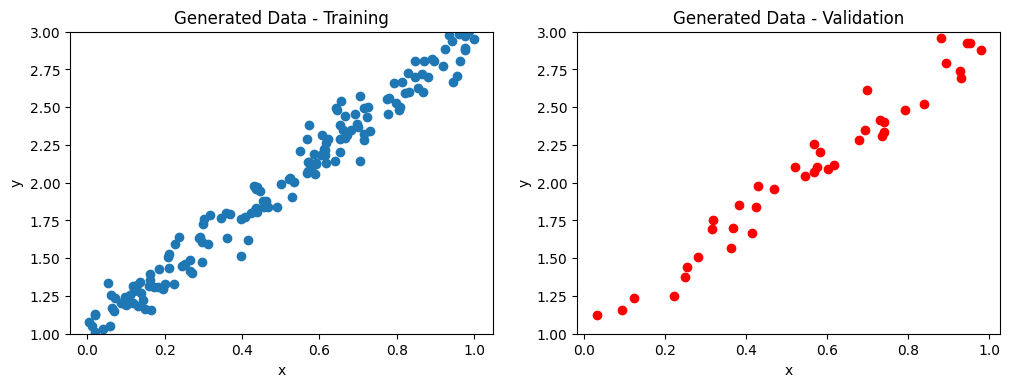

In [4]:
# Visualize synthetic data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
ax[0].scatter(x_train, y_train)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim([1, 3])
ax[0].set_title('Generated Data - Training')
ax[1].scatter(x_val, y_val, c='r')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_ylim([1, 3])
ax[1].set_title('Generated Data - Validation')
plt.show()

#### **Tensors**

In [5]:
# In PyTorch, tensors are multidimensional arrays that are similar to Numpy arrays
# The parameters (weights and biases) of neural networks are stored in tensors
scalar = torch.tensor(3.3333)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)
tensor = torch.randn((2, 3, 4), dtype=torch.float)

print(scalar)
print(vector)
print(matrix)
print(tensor)

# You can get the shape of a tensor using its size() method or its shape attribute
print(tensor.size(), tensor.shape)

tensor(3.3333)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[-0.5592, -0.3388, -1.8188,  0.7323],
         [-0.0228, -0.8001, -0.5056,  2.1915],
         [-0.8495, -0.4828,  1.2805,  0.1814]],

        [[-0.1652,  0.7495, -1.4669,  0.0329],
         [-1.8201,  0.1294,  0.3225,  1.4041],
         [ 0.4849, -0.6236,  0.9707, -0.0765]]])
torch.Size([2, 3, 4]) torch.Size([2, 3, 4])


In [6]:
# You can turn a Numpy array into a PyTorch tensor that uses a GPU, referred to as CUDA, for computations (referred to as CUDA)
# You can use cuda.is_available() to to determine if you have a GPU at your disposal (if not, use a CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# From Numpy arrays to PyTorch's tensors
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

# Check the class using the type method
print('Class type: ' + str(type(x_train_tensor)))

# Check the location (GPU or CPU) using the type attribute 
print('Location: ' + str(x_train_tensor.type()))

Class type: <class 'torch.Tensor'>
Location: torch.cuda.FloatTensor


In [7]:
# Training a neural network consists in optimizing its parameters (weights and biases) using gradient descent
# You need to tell PyTorch which tensors contain learnable parameters and should therefore allow for gradient computation
# You should therefore require gradient computation and assign tensors to a device at the moment of their creation
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print('Weight: ' + str(w))
print('Bias: ' + str(b))

Weight: tensor([-0.1908], device='cuda:0', requires_grad=True)
Bias: tensor([1.8408], device='cuda:0', requires_grad=True)


#### **Model training by gradient-descent in Numpy**


In [8]:
# Step 0: Parameter initialization
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)
print('Random bias initialization: ' + str(b))
print('Random weight initialization: ' + str(w))

Random bias initialization: [0.49671415]
Random weight initialization: [-0.1382643]


In [9]:
# Step 1: Forward pass 
# Computes the linear regression model's output
yhat = b + w * x_train

In [10]:
# Step 2: Loss computation 
# Use mean squared error to compute the loss
error = (yhat - y_train)
loss = (error ** 2).mean()
print('Loss: ' + str(loss))

Loss: 2.7275548090838577


In [11]:
# Step 3: Gradient computation
# Computes gradients for both parameters
b_grad = 2 * error.mean()
w_grad = 2 * (x_train * error).mean()
print('Gradient of the bias: ' + str(b_grad))
print('Gradient of the weight: ' + str(w_grad))

Gradient of the bias: -3.0683961524230683
Gradient of the weight: -1.8368761063029773


In [12]:
# Step 4: Parameter update
# Set learning rate
lr = 1e-1

# Update parameters to minimize loss
b = b - lr * b_grad
w = w - lr * w_grad

print('Updated bias: ' + str(b))
print('Updated weight: ' + str(w))

Updated bias: [0.80355377]
Updated weight: [0.04542331]


In [13]:
# We now know what four steps make up one iteration of gradient descent
# We can repeat the process until we have a good estimate of the bias and weight
# An epoch is completed when the error has been computed for all points in the dataset

# Defines number of epochs
n_epochs = 1000

# Step 0: Parameter initialization
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

# Batch gradient descent
for epoch in range(n_epochs):
    # Step 1: Forward pass
    yhat = b + w * x_train
    
    # Step 2: Loss computation 
    error = (yhat - y_train)
    loss = (error ** 2).mean()

    # Step 3: Gradient computation
    b_grad = 2 * error.mean()
    w_grad = 2 * (x_train * error).mean()
    
    # Step 4: Parameter update
    b -= lr * b_grad
    w -= lr * w_grad

print('Final bias: ' + str(b))
print('Final weight: ' + str(w))

Final bias: [1.01448577]
Final weight: [1.95700496]


#### **Model training by gradient descent in PyTorch**

In [14]:
# Step 0: Parameter initialization
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # bias
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # weight

# Set up stochastic gradient descent optimizer
lr = 1e-1 # learning rate
optimizer = optim.SGD([b, w], lr=lr)

# Number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1: Forward pass
    yhat = b + w * x_train_tensor

    # Step 2: Loss computation
    error = yhat - y_train_tensor
    loss = (error ** 2).mean()

    # Step 3: Gradient computation
    loss.backward()    
    
    # Step 4: Parameter update
    optimizer.step()
    optimizer.zero_grad()

print('Final bias: ' + str(b))
print('Final weight: ' + str(w))

Final bias: tensor([1.0145], device='cuda:0', requires_grad=True)
Final weight: tensor([1.9570], device='cuda:0', requires_grad=True)


#### **Neural network models in PyTorch**

In PyTorch, a model is represented by a Python class that inherits from the [**Module**](https://bit.ly/32MhAj8) class. Inheritance is a feature of object oriented programming that consists in deriving a class from a base class. A complex neural network, like the convolutional neural network you need in Part III, can be designed as a sequence of existing PyTorch classes. 

The necessary methods are:

* **`__init__(self)`**: it defines the parts that make up the model (in our case, parameters b and w)

* **`forward(self, x)`**: it the output, or model prediction, given an input

In [15]:
# Simple PyTorch model for linear regression
class ManualLinearRegression(nn.Module):
    def __init__(self):
        # Define the parameters (weight and bias) that define the model
        super().__init__()
        b = torch.randn(1, requires_grad=True, dtype=torch.float)
        w = torch.randn(1, requires_grad=True, dtype=torch.float)
        self.b = nn.Parameter(b)
        self.w = nn.Parameter(w)
        
    def forward(self, x):
        # Perform linear regression. Compute the outputs, or predictions, given an input
        return self.b + self.w * x

In [16]:
# Model instantiation & sending model to the GPU
model = ManualLinearRegression().to(device)

# Model inspection 
print(model.state_dict())

# Forward pass (do NOT use the forward method)
yhat = model(x_train_tensor)

OrderedDict([('b', tensor([0.3367], device='cuda:0')), ('w', tensor([0.1288], device='cuda:0'))])


In [17]:
# Model training using the train() PyTorch method. Beware: it does not train the model! 
# The train() method's purpose is to set the model to training mode (as opposed to validation mode)
lr = 1e-1
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Sets model to training mode
    model.train()

    # Step 1: Forward pass
    yhat = model(x_train_tensor)
    
    # Step 2: Loss computation
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3: Gradient computation
    loss.backward()

    # Step 4: Parameter update
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('b', tensor([1.0145], device='cuda:0')), ('w', tensor([1.9570], device='cuda:0'))])


In [18]:
# Automate the model training process  
# We get organize our code by making a function that determines the model training process 
# The optimizer (SGD, Adam), loss (MSE, cross-entropy) and neural network model are its inputs
# The function calls another function that performs one training step and returns the loss

def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "b" and "w" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

OrderedDict([('0.weight', tensor([[1.9570]], device='cuda:0')), ('0.bias', tensor([1.0145], device='cuda:0'))])


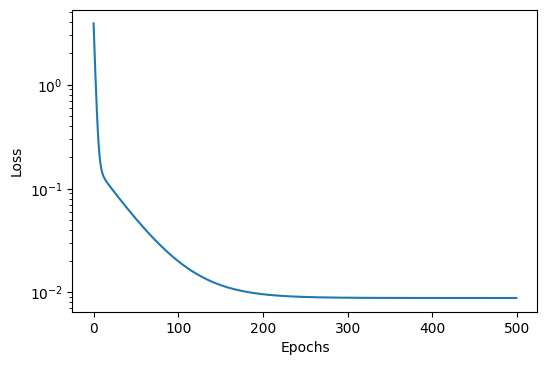

In [19]:
## Model Configuration ##
# Alternatively to the ManualLinearRegression class, we can use a PyTorch Sequential model 
# Our linear regression model has one Linear layer with a a single input and a single output
lr = 1e-1
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

## Model Training ##
# Create the training function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Iterative model training
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    # Perform one training step and return the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Check model's parameters
print(model.state_dict())

# Plot the loss 
plt.figure(dpi=100)
plt.plot(losses[:500])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

#### **PyTorch datasets and dataloaders**

In PyTorch, a dataset is represented by a Python class that inherits from the [**Dataset**](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class. You can think of it as a kind of a Python list of tuples, each tuple corresponding to one data point (features, label).

The necessary methods are:

* **`__init__(self)`**: it takes the arguments needed to build a list of tuples (e.g. CSV file name)

* **`__getitem__(self, index)`**: it allows the dataset to be indexed, so that the data is accessible like in a list (`dataset[i]`); it must return a tuple (features, label) corresponding to the requested data point

* **`__len__(self)`**: it should simply return the size of the whole dataset

There is no need to load the whole dataset in the constructor method (`__init__`). If your dataset is big (e.g. thousands of image files), loading it at once is not memory efficient. It is recommended to load them on demand (whenever `__get_item__` is called).


In [20]:
# Custom dataset that takes two tensors as arguments: one for the features, one for the labels 
# For any given index, our dataset class returns the corresponding slice of each of those tensors
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [21]:
# Define the training dataset using the custom dataset class
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()
train_data = CustomDataset(x_train_tensor, y_train_tensor)

# Define the validation dataset using the custom dataset class
x_val_tensor = torch.as_tensor(x_val).float()
y_val_tensor = torch.as_tensor(y_val).float()
val_data = CustomDataset(x_val_tensor, y_val_tensor)

Previously, we would simple send all our data to the GPU using `.to(device)` and use the whole training dataset at every training step. Alhtough batch gradient descent is a good approach for a small dataset, it will not scale to the 3D MRI data that you have to classify in Part III. Therefore, we now look at another approach that avoids loading our whole dataset into GPU tensors. The training data in `x_train_tensor` and the labels in `y_train_tensor` are CPU tensors.

Mini-batch gradient descent requires slicing the dataset. We are going to use the PyTorch’s [**DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class to split the data into mini-batches. The loader will behave like an iterator: it loops over the training data and fetchs a different mini-batch every time. During training, each mini-batch is then sent from the CPU to the device of the model (in our case, a GPU). 

For large datasets, loading data sample by sample into a CPU tensor using the dataset's `_getitem_` method and then sending all samples that belong to the same mini-batch at once to your GPU is the way to go in order to make the best use of your graphics card’s RAM.

In [22]:
# Define a dataloader for our dataset with a mini-batch size of 20 data points and allow for shuffling
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

Model parameters: OrderedDict([('0.weight', tensor([[1.9579]], device='cuda:0')), ('0.bias', tensor([1.0161], device='cuda:0'))])


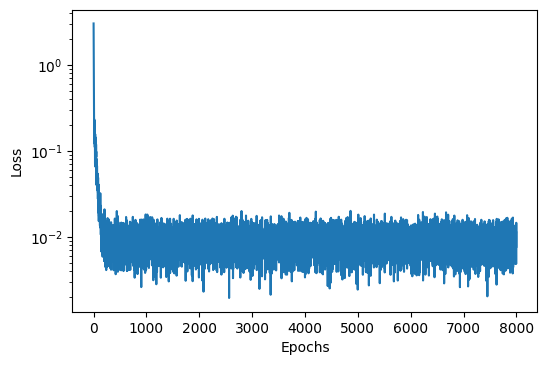

In [23]:
# Model Configuration
lr = 1e-1
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

# Model Training 
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # Send mini-batches to the device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
      
        loss = train_step_fn(x_batch, y_batch)
        losses.append(loss)
        
print('Model parameters: ' + str(model.state_dict()))

# Plot loss
plt.figure(dpi=100)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [24]:
# We can organize the code corresponding to mini-batch gradient descent in a function
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

#### **PyTorch model evaluation**

There are two things to consider when evaluating the generalization performance of a PyTorch model on a validation dataset: 

* [**torch.no_grad()**](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad): even though it won’t make a difference in our simple model, it is a good practice to wrap the validation inner loop with this context manager to disable any gradient calculation that you may inadvertently trigger (gradients belong in training, not in validation steps)
    
* [**eval()**](https://bit.ly/3ge8X4H): the only thing it does is setting the model to evaluation mode (just like its `train()` counterpart set the model to training mode), so the model can adjust its behavior regarding some operations like dropout

In [25]:
# Validation step function
def make_val_step_fn(model, loss_fn):
    def perform_val_step_fn(x, y):
        # Sets model to evaluation mode
        model.eval()
        
        # Step 1: Forward pass
        yhat = model(x)
        # Step 2: Loss computation
        loss = loss_fn(yhat, y)
        # No need for Steps 3 and 4 since we do not update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

# Dataloader of the validation dataset
val_loader = DataLoader(dataset=val_data, batch_size=20)

Model parameters: OrderedDict([('0.weight', tensor([[1.9575]], device='cuda:0')), ('0.bias', tensor([1.0160], device='cuda:0'))])


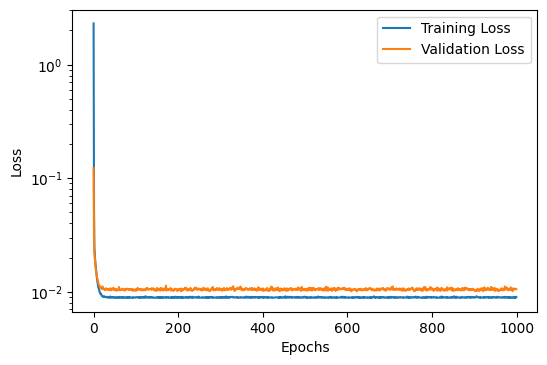

In [26]:
# Model Configuration
lr = 1e-1
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

# Model Training 
# Create the training function 
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Create the validation function 
val_step_fn = make_val_step_fn(model, loss_fn)

n_epochs = 1000
losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # Model Validation
    with torch.no_grad(): # No gradients! 
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss) 

print('Model parameters: ' + str(model.state_dict()))

# Plot loss
plt.figure(dpi=100)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()